## Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import tensorflow as tf
from tabulate import tabulate

## Download dữ liệu phân bón từ google drive về

In [2]:
!gdown --id 1Ca3JUKq-r9J_1KhUlpXleQhH2C2m6jWw
!gdown --id 1zjHTaRmrTsRg51e6_sN75uvvYlLlrXED

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ca3JUKq-r9J_1KhUlpXleQhH2C2m6jWw
To: /content/chemical_analysis.xlsx
100% 56.2k/56.2k [00:00<00:00, 86.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zjHTaRmrTsRg51e6_sN75uvvYlLlrXED
To: /content/spectra.xlsx
100% 4.38M/4.38M [00:00<00:00, 164MB/s]


In [3]:
chemical_df = pd.read_excel('/content/chemical_analysis.xlsx')
spectral_df = pd.read_excel('/content/spectra.xlsx')

## Tổng hợp thông tin giữa 2 bảng

In [4]:
spectra_data = spectral_df.iloc[:, 1:]
classes = chemical_df['Manure_type']
data = pd.concat([classes, spectra_data], axis=1)
spectra_data = data.iloc[:, 1:]

## Preprocessing

### Mã hóa Label

In [5]:
Class = data[['Manure_type']].values
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(Class)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
print("Số mẫu: ",spectra_data.shape[0])
print("Số chiều vector phổ NIR: ",spectra_data.shape[1])

Số mẫu:  490
Số chiều vector phổ NIR:  1003


### Làm mượt dữ liệu bằng Savitzky-Golay filter

In [7]:
spectra_data_cleaned = spectra_data.copy()
spectra_data_cleaned.iloc[:, 1:] = spectra_data_cleaned.iloc[:, 1:].apply(lambda x: x.str.replace(',', '.', regex=True))
spectra_data_cleaned = spectra_data_cleaned.iloc[:, 1:].astype('float64')
spectra_data_smoothed = spectra_data_cleaned.apply(lambda x: savgol_filter(x, 21, 3), axis=0)

### Chuẩn hóa dữ liệu bằng SNV

In [8]:
scaler = StandardScaler()
Spectra_data = scaler.fit_transform(spectra_data_smoothed)

### Split dữ liệu thành Train và Test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)

## Mô Hình MLP

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(categories='auto')
encoded_classes = encoder.fit_transform(encoded_classes.reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)
print(X_train.shape , y_train.shape)

(343, 1002) (343, 6)


In [11]:
def MLP():
  model = Sequential([
    layers.Dense(512, activation='relu', input_dim=1002),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(6 , activation='softmax')
  ])
  return model

model = MLP()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalFocalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 11s 160ms/step - loss: 0.1434 - accuracy: 0.8163 - val_loss: 0.0961 - val_accuracy: 0.8639
Epoch 2/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0853 - accuracy: 0.8688 - val_loss: 0.0630 - val_accuracy: 0.9048
Epoch 3/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0661 - accuracy: 0.8659 - val_loss: 0.0493 - val_accuracy: 0.8912
Epoch 4/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0564 - accuracy: 0.8717 - val_loss: 0.0497 - val_accuracy: 0.8503
Epoch 5/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0488 - accuracy: 0.8834 - val_loss: 0.0380 - val_accuracy: 0.9116
Epoch 6/500
11/11 [==============================] - 0s 8ms/step - loss: 0.0437 - accuracy: 0.8805 - val_loss: 0.0366 - val_accuracy: 0.9252
Epoch 7/500
11/11 [==============================] - 0s 7ms/step - loss: 0.0390 - accuracy: 0.8921 - val_loss: 0.0325 - val_accuracy: 0.9116
Epoch 8/50

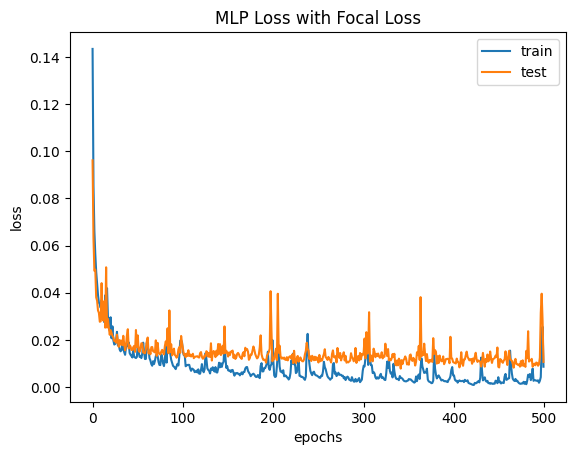

<Figure size 800x1300 with 0 Axes>

In [12]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('MLP Loss with Focal Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

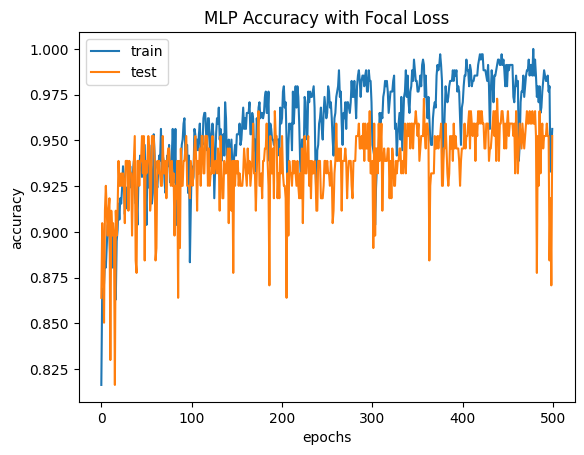

<Figure size 800x1300 with 0 Axes>

In [13]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('MLP Accuracy with Focal Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.9523809523809523
F1_Score:  0.8232119888018764
Precision:  0.9107090255685165
Recall:  0.7973728246318608


In [15]:
model.save_weights('MLP_FocalLoss.h5')

## Mô hình CNN

In [16]:
def convert_to_pseudo_image(Spectra_data):
  Spectra_data = tf.convert_to_tensor(Spectra_data)
  Spectra_data= tf.expand_dims(Spectra_data,axis=2)
  Spectra_data = tf.expand_dims(Spectra_data,axis=3)
  Spectra_data = tf.reshape(Spectra_data[:,0:968],(Spectra_data.shape[0],22,22,2))
  return Spectra_data

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)

In [18]:
X_train = convert_to_pseudo_image(X_train)
X_test = convert_to_pseudo_image(X_test)

In [19]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (343, 22, 22, 2)
X_test shape: (147, 22, 22, 2)
y_train shape: (343, 6)
y_test shape: (147, 6)


In [20]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def CNN():
  inputs = Input(shape=(22, 22, 2))
  x = layers.Conv2D(kernel_size=3, filters=16, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(kernel_size=3, filters=32, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(kernel_size=3, filters=64, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  return model

model = CNN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalFocalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 8s 59ms/step - loss: 0.2565 - accuracy: 0.4723 - val_loss: 0.2888 - val_accuracy: 0.2993
Epoch 2/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1740 - accuracy: 0.7318 - val_loss: 0.2838 - val_accuracy: 0.7007
Epoch 3/500
11/11 [==============================] - 0s 8ms/step - loss: 0.1326 - accuracy: 0.8309 - val_loss: 0.2787 - val_accuracy: 0.8231
Epoch 4/500
11/11 [==============================] - 0s 9ms/step - loss: 0.1022 - accuracy: 0.8426 - val_loss: 0.2709 - val_accuracy: 0.8571
Epoch 5/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0905 - accuracy: 0.8367 - val_loss: 0.2588 - val_accuracy: 0.8571
Epoch 6/500
11/11 [==============================] - 0s 10ms/step - loss: 0.0804 - accuracy: 0.8455 - val_loss: 0.2460 - val_accuracy: 0.8571
Epoch 7/500
11/11 [==============================] - 0s 9ms/step - loss: 0.0743 - accuracy: 0.8455 - val_loss: 0.2326 - val_accuracy: 0.8571
Epoch 8/50

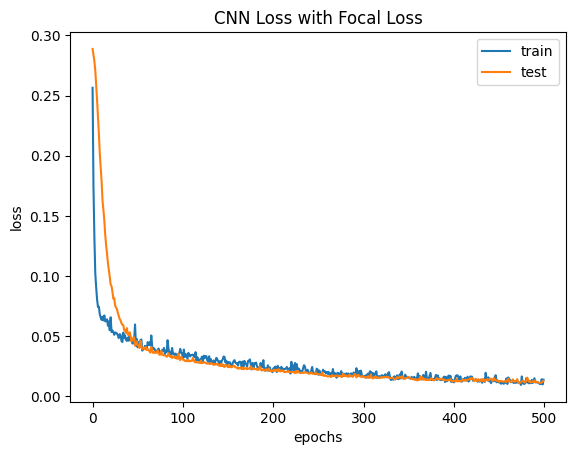

<Figure size 800x1300 with 0 Axes>

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('CNN Loss with Focal Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

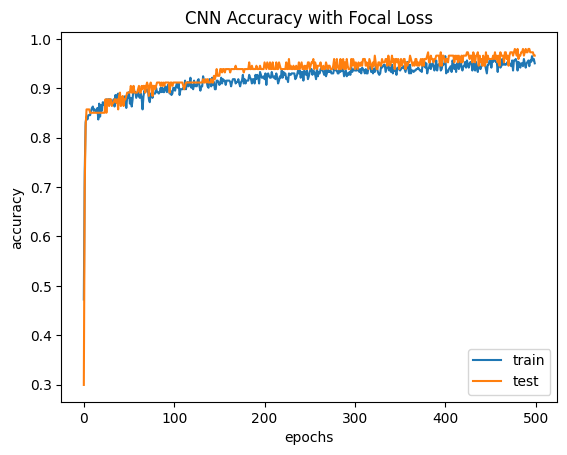

<Figure size 800x1300 with 0 Axes>

In [22]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('CNN Accuracy with Focal Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 3ms/step
Accuracy: 0.9659863945578231
F1_Score:  0.8384916365685599
Precision:  0.9867786391042205
Recall:  0.7888888888888889


In [24]:
model.save_weights('CNN_FocalLoss.h5')

## ResNet

In [25]:
X_train, X_test, y_train, y_test = train_test_split(Spectra_data, encoded_classes, stratify= encoded_classes, shuffle=True, test_size=0.3, random_state=2)
X_train = convert_to_pseudo_image(X_train)
X_test = convert_to_pseudo_image(X_test)

In [26]:
def residual_block(x, filters):

  x1 = layers.Conv2D(kernel_size=1, filters=filters, padding="same")(x)
  x1 = layers.BatchNormalization()(x1)

  x2 = layers.Conv2D(kernel_size=3, filters=filters, padding="same")(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = layers.ReLU()(x2)
  x2 = layers.Conv2D(kernel_size=3, filters=filters, padding="same")(x2)
  x2 = layers.BatchNormalization()(x2)

  out = layers.Concatenate()([x1, x2])
  out = layers.ReLU()(out)

  return out

def ResNet():

  inputs = Input(shape=(22, 22, 2))
  x = residual_block(inputs,16)
  x = residual_block(x,32)
  x = residual_block(x,64)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(6, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=x)
  return model

In [27]:
model = ResNet()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = CategoricalFocalCrossentropy(), metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/500
11/11 [==============================] - 8s 86ms/step - loss: 0.3367 - accuracy: 0.3149 - val_loss: 0.2941 - val_accuracy: 0.5034
Epoch 2/500
11/11 [==============================] - 0s 14ms/step - loss: 0.1912 - accuracy: 0.6443 - val_loss: 0.2730 - val_accuracy: 0.7619
Epoch 3/500
11/11 [==============================] - 0s 13ms/step - loss: 0.1379 - accuracy: 0.7930 - val_loss: 0.2533 - val_accuracy: 0.7619
Epoch 4/500
11/11 [==============================] - 0s 12ms/step - loss: 0.0994 - accuracy: 0.8309 - val_loss: 0.2353 - val_accuracy: 0.7891
Epoch 5/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0847 - accuracy: 0.8571 - val_loss: 0.2184 - val_accuracy: 0.8367
Epoch 6/500
11/11 [==============================] - 0s 13ms/step - loss: 0.0892 - accuracy: 0.8367 - val_loss: 0.2030 - val_accuracy: 0.8367
Epoch 7/500
11/11 [==============================] - 0s 14ms/step - loss: 0.0708 - accuracy: 0.8601 - val_loss: 0.1865 - val_accuracy: 0.8503
Epoch 

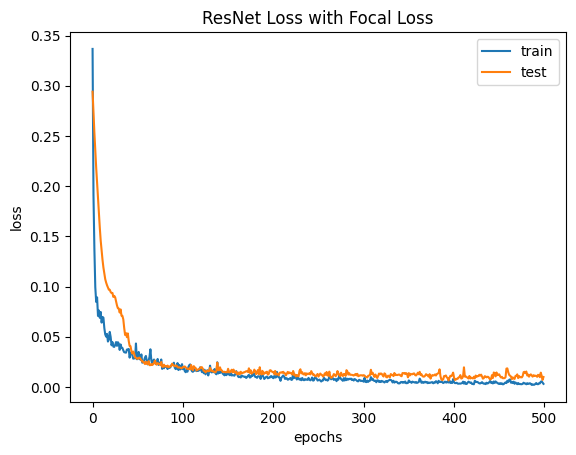

<Figure size 800x1300 with 0 Axes>

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('ResNet Loss with Focal Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

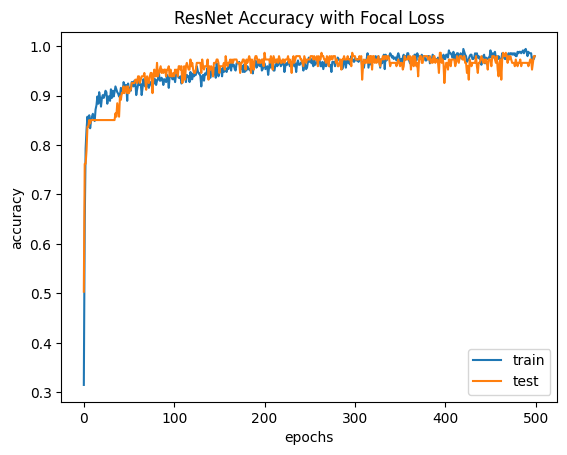

<Figure size 800x1300 with 0 Axes>

In [29]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('ResNet Accuracy with Focal Loss')
plt.legend()
plt.figure(figsize=(8, 13))

plt.show()

In [30]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

print("Accuracy:",accuracy_score(y_test, y_pred))
print("F1_Score: ",f1_score(y_test, y_pred, average='macro'))
print("Precision: ",precision_score(y_test, y_pred, average='macro'))
print("Recall: ",recall_score(y_test, y_pred, average='macro'))

5/5 [==============================] - 0s 4ms/step
Accuracy: 0.9795918367346939
F1_Score:  0.9211001642036125
Precision:  0.9922905525846702
Recall:  0.8777777777777778


In [31]:
model.save_weights('ResNet_FocalLoss.h5')